#Test of  performance with changing number of features

In [0]:
# Data managment 
import pandas as pd 
import numpy as np 

#Visualisation and statistics
import matplotlib.pyplot as plt
import seaborn as sns
from fastprogress import master_bar, progress_bar

sns.set(style="darkgrid")
%matplotlib inline

#Additional
import pickle
import random
import os

##Get all important files with direct download


*   Func_skorchSimpleAE.py - Functional version of skorch_SimpleAE.ipynb
*   scaled_data.csv - data proton-proton, scaled and prepared for use
*   feature_rank.csv -  ranking of features redundancy






In [0]:
%%capture
if not os.path.isfile('all_scaled0_1.csv'): 
    !wget 'https://drive.google.com/uc?export=download&id=1-ET9vXPKudU92XuWeR0wIL67byS2llq-' -O all_scaled0_1.csv
if not os.path.isfile('feature_rank.csv'): 
    !wget 'https://drive.google.com/uc?export=download&id=1VniFAb_J0uHS0PCZMvd7JCEWtX3O8V3t' -O feature_rank.csv
if not os.path.isfile('func_skorchSimpleAE.py'):
    !wget 'https://drive.google.com/uc?export=download&id=1ldpsuXjzPYdIArniWoyei7NuAvMyuNLZ' -O func_skorchSimpleAE.py

!pip install skorch 

In [0]:
#get simple autoencoder 
import func_skorchSimpleAE as ae_mod

In [4]:
#get data
data = pd.read_csv('all_scaled0_1.csv',index_col=0)
data = data.drop(['chunkID','run','period'], axis = 1)
labels = data['label']
print(data.shape)
data.head()

(3429, 234)


,bz,meanTPCnclF,rmsTPCnclF,meanTPCChi2,rmsTPCChi2,slopeATPCnclF,slopeCTPCnclF,slopeATPCnclFErr,slopeCTPCnclFErr,meanTPCncl,rmsTPCncl,slopeATPCncl,slopeCTPCncl,slopeATPCnclErr,slopeCTPCnclErr,hasRawQA,rawClusterCounter,rawSignalCounter,offsetdZA,slopedZA,offsetdZC,slopedZC,offsetdZAErr,slopedZAErr,offsetdZCErr,slopedZCErr,offsetdZAchi2,slopedZAchi2,offsetdZCchi2,slopedZCchi2,offsetdZAPos,slopedZAPos,offsetdZCPos,slopedZCPos,offsetdZAErrPos,slopedZAErrPos,offsetdZCErrPos,slopedZCErrPos,offsetdZAchi2Pos,slopedZAchi2Pos,...,MIPattachSlopeC,MIPattachSlopeA,resolutionMIP,meanMIP,meanMIPele,resolutionMIPele,electroMIPSeparation,tpcItsMatchA,tpcItsMatchHighPtA,tpcItsMatchC,tpcItsMatchHighPtC,phiPull,phiPullHighPt,ptPull,ptPullHighPt,yPull,yPullHighPt,zPull,zPullHighPt,lambdaPull,lambdaPullHighPt,tpcConstrainPhiA,tpcConstrainPhiC,meanPTRelativeA,medianPTRelativeA,rmsPTRelativeA,meanPTRelativeC,medianPTRelativeC,rmsPTRelativeC,meanHVandPTGainCorrIROC,medianHVandPTGainCorrIROC,rmsHVandPTGainCorrIROC,meanHVandPTGainCorrOROC,medianHVandPTGainCorrOROC,rmsHVandPTGainCorrOROC,meanVDriftCorr,medianVDriftCorr,rmsVDriftCorr,interactionRate,label
0,0.0,0.650378,0.212065,0.586648,0.299807,0.567304,0.506033,0.029799,0.506033,0.661859,0.130696,0.638500,0.432987,0.026360,0.432987,1.0,0.586239,0.630747,0.676500,0.505639,0.456515,0.479150,0.029047,0.025431,0.009684,0.011481,0.066360,0.066360,0.126838,0.126838,0.539923,0.675482,0.422997,0.501126,0.008516,0.015049,0.004693,0.005500,0.018955,0.018955,...,0.842762,0.992611,0.094750,0.032376,0.539362,0.377138,0.013496,0.532074,0.573832,0.586826,0.582128,0.279488,0.558088,0.489128,0.478282,0.057793,0.397318,0.303648,0.494765,0.564013,0.819216,0.365811,0.029029,0.644374,0.643025,0.030060,0.645929,0.644593,0.029592,0.644385,0.643058,0.003333,0.731516,0.730402,0.030475,0.062052,0.062018,0.033067,0.224399,0.0
1,0.0,0.652363,0.219786,0.579001,0.299619,0.553643,0.490807,0.028887,0.490807,0.662852,0.129801,0.622553,0.431335,0.025804,0.431335,1.0,0.586239,0.630747,0.672718,0.471739,0.656468,0.622429,0.028192,0.024807,0.010054,0.011773,0.098105,0.098105,0.201625,0.201625,0.526042,0.667218,0.626295,0.612202,0.008705,0.014936,0.004920,0.005719,0.078152,0.078152,...,0.828729,0.992595,0.091434,0.033806,0.539610,0.377678,0.013927,0.529813,0.549569,0.583827,0.581842,0.295763,0.618659,0.506106,0.508984,0.096134,0.428699,0.344592,0.458420,0.559882,0.844903,0.279536,0.084570,0.645829,0.644559,0.044541,0.647352,0.646086,0.044614,0.645843,0.644604,0.005065,0.732617,0.731569,0.046314,0.061865,0.061878,0.008953,0.224399,0.0
2,0.0,0.656779,0.213371,0.582115,0.302841,0.576802,0.486826,0.028507,0.486826,0.664891,0.128520,0.622628,0.414198,0.025567,0.414198,1.0,0.586239,0.630747,0.709053,0.424595,0.774050,0.716557,0.027634,0.024176,0.010050,0.011627,0.102944,0.102944,0.235948,0.235948,0.559119,0.630758,0.748653,0.689030,0.008364,0.014483,0.004980,0.005612,0.144460,0.144460,...,0.829774,0.993051,0.089755,0.023854,0.539159,0.377654,0.013651,0.534614,0.567858,0.584458,0.586257,0.281763,0.572836,0.508496,0.493338,0.091167,0.420849,0.341413,0.461882,0.561373,0.828174,0.319029,0.133775,0.645117,0.644090,0.046651,0.646626,0.645604,0.046878,0.645142,0.644119,0.005186,0.732088,0.731203,0.047418,0.061668,0.061682,0.027615,0.224399,0.0
3,0.0,0.650338,0.217591,0.590880,0.307098,0.573718,0.465535,0.029239,0.465535,0.657125,0.127972,0.628921,0.413237,0.025642,0.413237,1.0,0.586239,0.630747,0.684981,0.453121,0.865839,0.786867,0.029305,0.025690,0.010495,0.012253,0.074307,0.074307,0.257066,0.257066,0.539152,0.660319,0.849890,0.748568,0.008935,0.015657,0.005144,0.005934,0.084640,0.084640,...,0.835028,0.992149,0.091761,0.025925,0.539396,0.377537,0.014017,0.520301,0.541670,0.572863,0.589802,0.270435,0.602295,0.511802,0.537189,0.105408,0.439337,0.365844,0.496001,0.529956,0.807985,0.251844,0.160170,0.639891,0.637870,0.174869,0.641396,0.639382,0.175343,0.639929,0.637938,0.019871,0.728152,0.726535,0.181697,0.061461,0.061460,0.007084,0.224399,0.0
4,0.0,0.654

## Prepare Autoencoder Module

In [5]:
help(ae_mod.getAEscores)

Help on function getAEscores in module func_skorchSimpleAE:

getAEscores(data, epochs, train_on_all)
    Return average MSE of OUTLIERS and CORRECT samples in this order.
    train_on_all parameter means that outlier will be alsoe included in training.



## Prepare SVM Module

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
clf = SVC(kernel = 'linear', C = 1.0)

def getSVMscore(data, clf):
    labels = data['label']
    data = data.drop(['label'], axis = 1)

    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,stratify=labels)
    clf.fit(X_train, y_train)

    pred = clf.predict(X_test)
    score = accuracy_score(y_test, pred)
    score_bal = balanced_accuracy_score(y_test, pred)

    return score, score_bal

##Set parameters and prepare ranking for usage

In [0]:
#Set parameters
no_epochs = 50
features_to_drop = 200 
drop_at_once = 5

In [8]:
#get data frame with ranks of features
ranks_raw = pd.read_csv('feature_rank.csv',index_col=0)
print(ranks_raw.shape)
ranks_raw.head()

(233, 2)


,logreg,lasso
0,MIPattachSlopeC,bz
1,resolutionMIPele,meanTPCnclF
2,meanMIP,rmsTPCnclF
3,MIPattachSlopeA,meanTPCChi2
4,meanMIPele,rmsTPCChi2


## Get performances for decresing numbers of features 

In [9]:
ranks = ranks_raw.copy()

#Create dict of data sets for training 
#Create dict of scores lists
data_dict = {}
score_ae_dict = {}
score_svm_dict = {}

for col in ranks.columns:
    data_dict[col] = data.copy()
    score_ae_dict[col] = []
    score_svm_dict[col] = []

#Iterate over batches of features to drop + 1 for 1st iteration when no features are droped
mb = master_bar(range(round(features_to_drop/drop_at_once)))

for i in mb: 
    # here do training of autoencoder and score getting before dropping anything
    for col in progress_bar(ranks.columns, parent=mb):
        #Train autoecoder, test it and return scores
        s_ae = ae_mod.getAEscores(data_dict[col], no_epochs, train_on_all = False)
        s_svm = getSVMscore(data_dict[col],clf)
        #Add score to list 
        score_ae_dict[col].append(s_ae)
        score_svm_dict[col].append(s_svm)

    #Drop features that are next in rank and also cut rows of rank
    drop = ranks[:drop_at_once]
    for col in ranks.columns:
        data_dict[col].drop(drop[col].values, inplace=True, axis = 1)
    ranks.drop(ranks.index[:drop_at_once], inplace=True)

    mb.write(f'Finished loop {i+1}.')

In [0]:
#Pickle data to be able to use it later

with open("scores.txt", "wb") as fp:   #Pickling
  pickle.dump({'ae': score_ae_dict, 'svm': score_svm_dict}, fp)

## 1st Visualization

Process went as follows, for each ranking (greedy, rfe, etc.) autoencoder was trained and tested. Average MSE from test of outliers and correct samples were obtained. Then 5 features conciderd the worse for each method were dropped and traning and testing were repeated. This whole process was repeated untill 200 features (almost all) were dropped.

At all time same proportions of number of nodes in layers to number of features in data were kept to exclude changing architecture effects. 

**Left graph** showes how score (avg MSE outliers - avg MSE correct samples) is changing when worse features from each group are being elimnated. 

**Right graph** showes how MSE of correct samples is changing, so how ability to recreate input features is changing. Lower the MSE, better working autoencoder.


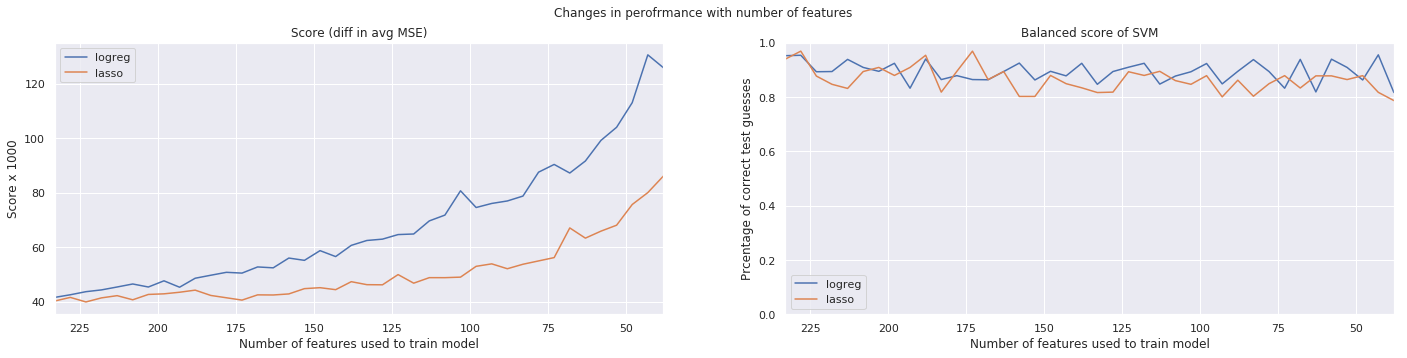

In [11]:
#Load scores from file and draw a graph
with open("scores.txt", "rb") as fp:   
  scores = pickle.load(fp)

  ae_dict = scores['ae']
  svm_dict = scores['svm']

#Generate values for X axis  
X = np.arange(ranks_raw.shape[0],ranks_raw.shape[0] - features_to_drop, -drop_at_once)

#Crate figure
fig, axs = plt.subplots(nrows=1,ncols=2, figsize=(24,5))
fig.suptitle('Changes in perofrmance with number of features')

axs[0].set_title("Score (diff in avg MSE)")
axs[0].set(xlabel='Number of features used to train model', ylabel='Score x 1000')

axs[1].set_title("Balanced score of SVM")
axs[1].set(xlabel='Number of features used to train model', ylabel='Prcentage of correct test guesses')


for rank in ae_dict.keys(): #Could be other one
    ae_score = [(outl - corr) * 1000 for outl, corr in ae_dict[rank]] # Scale by 1000 for clarence
    svm_score = [sb  for s, sb in svm_dict[rank]] # Show balanced score
    axs[0].plot(X, ae_score, label= rank) 
    axs[1].plot(X, svm_score, label= rank) 

#Set common and extra parameters 
axs[1].set_ylim([0,1])
for ax in axs:
    ax.invert_xaxis()
    ax.set_xlim(X[0], X[-1])
    ax.legend(loc='best')

plt.savefig('scores.png', bbox_inches='tight')

##Check changes of MSE for most effective rank

For the best working method (RFE) MSE for otliers and correct samples was shown on one plot. So it is break down of the score.

We can see that it make sens that score is growing as ability of recreating correct samples is basiclly same throught the entire time and MSE of outliers is growing. 

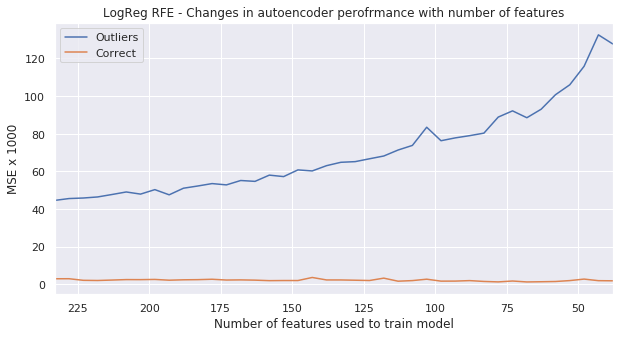

In [12]:
#Load scores from file and draw a graph
with open("scores.txt", "rb") as fp:   
    scores = pickle.load(fp)
    ae_dict = scores['ae']

#Generate values for X axis  
X = np.arange(ranks_raw.shape[0],ranks_raw.shape[0] -  features_to_drop, -drop_at_once)

#Crate figure
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title("LogReg RFE - Changes in autoencoder perofrmance with number of features")
ax.set(xlabel='Number of features used to train model', ylabel='MSE x 1000')

outl, corr = zip(*ae_dict['logreg'])
outl = [i * 1000 for i in outl] # Scale by 1000 for clarence
corr = [i * 1000 for i in corr] # Scale by 1000 for clarence
ax.plot(X, outl, label= 'Outliers') 
ax.plot(X, corr, label= 'Correct')

#Set common parameters 
ax.invert_xaxis()
ax.set_xlim(X[0], X[-1])
ax.legend(loc='best')

plt.savefig('scores_msecomp.png', bbox_inches='tight')